# Physical distancing

{index}`Quarantine <quarantine>` seems to be very effective, especially when carried out strongly enough and when combined with effective detection of exposed individuals. But you need to get a lot right for it to work. Maybe there's another way?

```{margin}

Some people *never* develop symptoms: for some reason their immune systems suppress the disease enough to keep them well, but not enough to eliminate it and stop them being infectious. The most famous case of this phenomenon is "{index}`Typhoid Mary`"{cite}`MTK13`, who infected a large number of people with typhoid fever despite showing no symptoms herself.
```

Let's go back to basics. In {index}`SEIR`-style diseases we have the possibility of individuals walking around and spreading the disease without showing any symptoms. There is by definition no way (absent testing) to spot these individuals until (and unless) they show symptoms. So the challenge is to stop these infectious-but-asymptomatic individuals from coming into contact with susceptible individuals.

What if we re-structure the contact network so that people only have contact with a small group of people, and reduce the amount of mixing between those groups? If someone is infected in spite of everything then they'll probably infect their own group, but they'll be less opportunity to infect other groups. This strategy is referred to as **{index}`physical distancing`**, reducing and re-structuring the connections within a population.   

## A physically-distanced contact network

Physical distancing is another topological approach to epidemic control. It works by changing the network over which the disease operates, rather than addressing the disease itself. Such approach is well-suited to new diseases and those for which there are few effective therapies. 

In [1]:
import numpy
import networkx
import epyc
import epydemic
import pandas
import mpmath

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'png'
matplotlib.rcParams['figure.dpi'] = 300
import matplotlib.pyplot as plt
import seaborn
matplotlib.style.use('seaborn')
seaborn.set_context("notebook", font_scale=1.75)

What does "physical distancing" mean in network terms? We can understand it best by thinking about the actual conditions of socially-distant lockdown, and then re-creating this structure as a network.
```{margin}

Sometimes referred to as **{index}`social distancing <see: social distancing;physical distancing>`**, although that feels like an oxymoron: it also sounds uncomfortably close to "social isolation", which indeed is one of its major dangers as a technique.
```

The idea of physical distancing is to place individuals in small "{index}`bubbles <contact bubbles>`" of {index}`contact` &ndash; typically just their own immediate family &ndash; with whom they interact strongly, and weaken the connections that any family member has with individuals in other bubbles. Within a bubble, infection of one person will probably transfer quickly to most or all all of the other members. But the ability of the disease to pass between bubbles is substantially reduced, since there is relatively little contact between them. One can reduce the inter-bubble transmission even further using quarantine when someone realises they are infected.

In network terms, the {index}`bubbles <complete graph>` are {ref}`complete graphs <sec:network-complete>` (everyone in a bubble meets everyone else) whose size depends on the size of the family. We could set all families to the same size, say 4; alternatively we could draw family sizes from some probability distribution where the average size of a family is 4.5 (2 adults with the proverbial 2.5 children) but we allow larger and smaller families to occur. Larger families risk more infections if a member is infected.

We now need to link the bubbles. In each bubble, some person or people meet with the outside world: perhaps they're the designated shopper, or someone in a key role whose work brings them into contact with others. We then need to connect these people to other bubbles.

This description still leaves quite a lot to be decided:

- What is the distribution of family sizes? Are large families really unusual? Or do they follow a "normal" distribution?
- How many people in each family connect to the outside? Is it always one or two? Might a large family have more contacts?
- How do those in contact outside their family group connect with others? Are some people significantly more connected than others?

These decisions are simply {index}`additional <degrees of freedom>` {ref}`degrees of freedom <sec:seir-degrees-of-freedom>` (again) for our model &ndash; with all that this entails.

Creating such a network means addressing all these issues. There's a trick we can perform, though. Notice that while the detailed choices change, the structure of the network doesn't. This means that, just as our disease models have parameters that we can change, so does our socially-distanced network &ndash; with the difference that the network parameters are given by choices of probability distributions as well as single numbers. But the solution is the same: define what it means to build the network, providing these distributions as parameters that are "plugged in" to the same structure-building process.

Building the network involves a complicated piece of code &ndash; the most complicated we've seen so far.

In [2]:
def distanced_graph(N, clusterSizeDistribution, contactDistribution, clusterContactDistribution):
    # build the initial graph
    g = networkx.Graph()
    
    # build the clusters, each being a complete
    # graph K_s of size s, labelled uniquely 
    # within the overall graph
    rng = numpy.random.default_rng()
    n = 0
    cid = 1
    clusters = []
    while n < N:
        # build the cluster's graph with a random size
        s = clusterSizeDistribution()
        K_s = networkx.complete_graph(s)
        
        # relabel the cluster graph so all nodes in the final
        # social distence graph have unique integer labels
        networkx.relabel_nodes(K_s, lambda l: n + l,
                               copy=False)
        
        # add to the graph and list of clusters
        # label edges with the cluster they belong to
        # (numbered from 1) and the size of the cluster
        g.add_nodes_from(K_s.nodes,
                         cluster=cid, cluster_size=s)
        g.add_edges_from(K_s.edges,
                         cluster=cid, cluster_size=s)
        clusters.append(K_s)
        n += s
        cid += 1
        
    # draw the number of contact nodes per cluster from
    # from the distribution
    contacts = []
    for c in clusters:
        s = c.order()
        d = contactDistribution(s)
        contacts.append(d)
        
    # decide on the arity of each contact node
    stubs = []
    for i in range(len(clusters)):
        c = clusters[i]
        # first i node labels (since all nodes are
        # identical in K_s) 
        ls = list(c.nodes())[:contacts[i]]   
        for l in ls:
            # draw the number of contacts for this node
            e = clusterContactDistribution(n)
            
            # append e copies of the node label to
            # the list of stubs
            stubs.extend([l] * e)
    
    # if number of stubs isn't even, add one to a
    # randomly-chosen node (don't favour
    # already-high-degree nodes
    if len(stubs) % 2 > 0:
        us = list(set(stubs))                
        j = rng.integers(len(us))
        stubs.append(us[j])
        
    # shuffle the stubs until there are no edge
    # pair with the same endpoints
    rng.shuffle(stubs) # may leave loops
    while True:
        # look for pairtings of stubs and others
        # within the same cluster, and break them
        # randomly (without changing the degree
        # distribution)
        swaps = 0
        for i in range(0, len(stubs), 2):
            if g.nodes[stubs[i]]['cluster'] == g.nodes[stubs[i + 1]]['cluster']:
                # self loop, swap with another
                # randomly-chosen stub
                j = rng.integers(len(stubs))
                t = stubs[i + 1]
                stubs[i + 1] = stubs[j]
                stubs[j] = t
                
                swaps += 1
        if swaps == 0:
            # no swaps, we're finished
            break

    # connect the nodes by pulling pairs of stubs
    # and creating an edge between them
    for i in range(0, len(stubs), 2):
        # label inter-bubble edges as cluster 0 of size 0
        g.add_edge(stubs[i], stubs[i + 1],
                   cluster=0, cluster_size=0)
    
    # return the graph and list of cluster sizes
    return (g, list(map(lambda h: h.order(), clusters)))

This function takes four {index}`parameters <parameter>` &ndash; the size of network and three probability-distribution functions &ndash; and returns a network and a list of the bubble sizes. Within the network it creates the social bubbles and labels them uniquely, and then connects the bubbles together randomly. 

## Making some choices

We can't get away from making choices about these {index}`degrees of freedom` indefinitely, though &ndash; and in fact that time has arrived.

Since we're interested in large-scale phenomena, let's make some simple choices:

- Families whose sizes are normally-distributed integers with a mean of 4.5 and a standard deviation of 2
- A {index}`normal distribution <distribution;normal>` of contacts in each family
- {index}`Exponentially-distributed <distribution;exponential>` links betyween connections, to allow for very connected individuals

Since it makes no sense to allow entirely isolated families, those with no size, and "connected" individuals with no contacts, we cut off all the distributions with a minimum of 1.

In [3]:
def averageFamily():
    rng = numpy.random.default_rng()
    return max(int(rng.normal(4.5, 2)), 1)

In [4]:
def coupleOfContacts(s):
    rng = numpy.random.default_rng()
    return max(int(rng.normal(min(s / 2, 2), 1)), 1)    

In [5]:
def expInterBubble(n):
    rng = numpy.random.default_rng()
    return max(int(rng.exponential(10.0)), 1)

These three functions, coupled with the network size, are enough to build our network.

In [8]:
N = 1000

In [9]:
(g, clusters) = distanced_graph(N, averageFamily, coupleOfContacts, expInterBubble)

We can check the various elements of this network. For example, we can check what range of family "bubble" sizes we have, and how connected the various contact individuals are.

In [8]:
print('Mean family size of {s:.2f} (range {minf}-{maxf})'.format(s=numpy.mean(clusters), minf=min(clusters), maxf=max(clusters)))
print('Most connected individual has {k} contacts'.format(k=max(dict(g.degree()).values())))

Mean family size of 4.00 (range 1-10)
Most connected individual has 55 contacts


We could also draw the network to inspect it, colouring the nodes with the size of cluster they belong to &ndash; although that turns out not to be especially revealing.

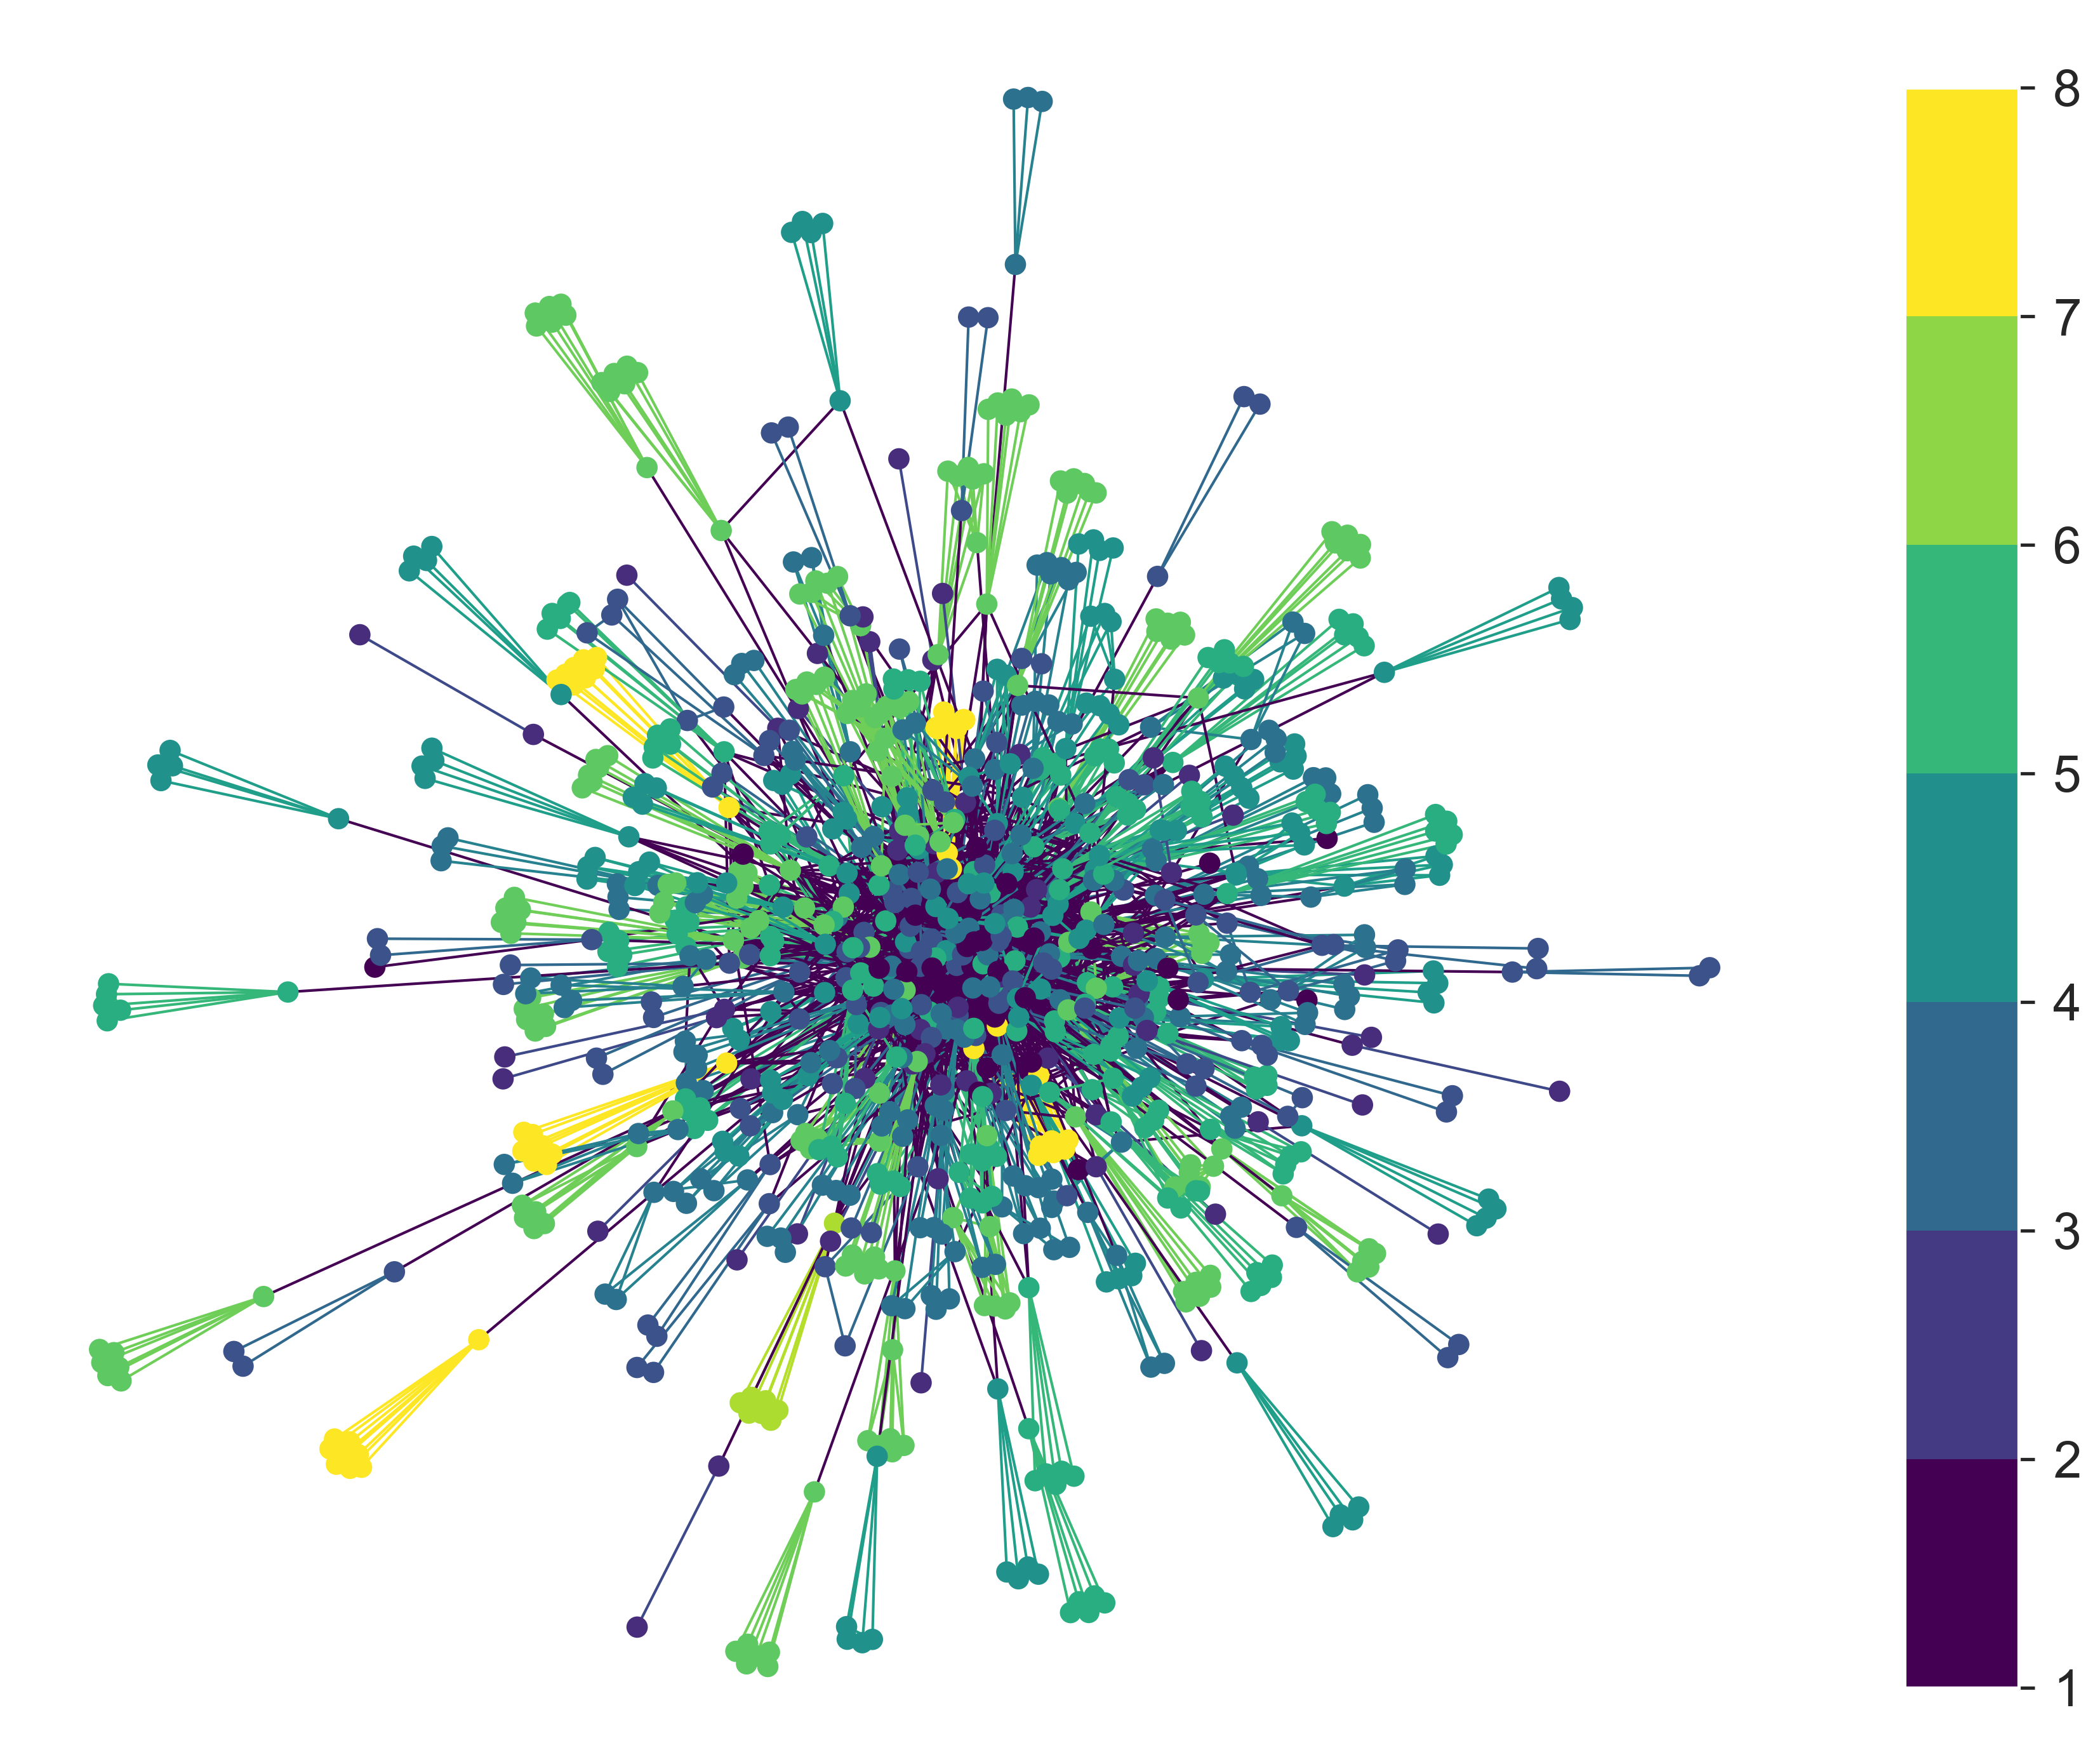

In [11]:
def draw_distanced(g, cmap=None,
                   color='cluster_size',
                   ax=None):
    # fill in defaults
    if cmap is None:
        cmap = plt.get_cmap('viridis')
    if ax is None:
        ax = plt.gca()
    
    # work out the colours 
    ncs = list(map(lambda n: g.nodes[n][color],
                   g.nodes()))
    ecs = list(map(lambda e: g.edges[e][color],
                   g.edges()))
               
    # draw with spring layout, which seems to
    # give good results
    networkx.draw_spring(g,
                         ax=ax,
                         with_labels=False,
                         node_size=50,
                         node_color=ncs,
                         edge_color=ecs,
                         cmap=cmap,
                         edge_cmap=cmap)

fig = plt.figure(figsize=(12, 12))
ax = fig.gca()

# draw network
cmap = plt.get_cmap('viridis')
draw_distanced(g, cmap=cmap)

# add key (see https://matplotlib.org/examples/api/colorbar_only.html)
bounds = list(range(min(clusters), max(clusters)))
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
ax1 = fig.add_axes([0.95, 0.15, 0.05, 0.7])
cb2 = matplotlib.colorbar.ColorbarBase(ax1, cmap=cmap,
                                    norm=norm,
                                    boundaries=bounds,
                                    ticks=bounds,
                                    spacing='proportional',
                                    orientation='vertical')

plt.savefig('physical-distancing.png', dpi=300)
_ = plt.show()

This isn't a useless plot, once we know that more highly-connected clusters sit in the centre with less-connected clusters pushed to the outside. We can see these less-connected clusters, and in particular see that they have a range of colours, indicating that they're of different sizes &ndash; and therefore giving confidence that the algorithm hasn't (for example) only made large clusters highly connected.    

## Disease and distancing

Now we can run a disease process over our network. We'll stick to {index}`SIR` to reduce the number of degrees of freedom we have to deal with: running with {index}`SEIR` would be easy to do too, of course, but presents us with even more choices.

What do we expect from a disease in these circumstances? The purpose of physical distancing is to reduce the connectivity of people, which (all things being equal) should reduce the disease's spread. But it does so by building tight clusters of individuals within bubbles, meaning that infecting one person is likely to infect everyone. And we've used an exponential distribution of contacts to allow the creation of high-degree hubs, meaning that infecting one of these will potentially infect a lot of others.

The best we can probably say at this stage, then, is that ... it's complicated. Which is just the sort of situation simulation is intended for.

In [303]:
lab = epyc.ClusterLab(profile='hogun',
                      notebook=epyc.JSONLabNotebook('datasets/sir-phydist.json', create=True))

In [271]:
with lab.sync_imports():
    import time
    import networkx
    import epyc
    import epydemic
    import numpy
    import mpmath
print('{n} engines available'.format(n = lab.numberOfEngines()))

importing time on engine(s)
importing networkx on engine(s)
importing epyc on engine(s)
importing epydemic on engine(s)
importing numpy on engine(s)
importing mpmath on engine(s)
78 engines available


In [4]:
# from https://nbviewer.jupyter.org/gist/minrk/4470122
def pxlocal(line, cell):
    ip = get_ipython()
    ip.run_cell_magic("px", line, cell)
    ip.run_cell(cell)
get_ipython().register_magic_function(pxlocal, "cell")    

In [5]:
%%pxlocal

class MonitoredSIR(epydemic.SIR, epydemic.Monitor):
 
    def __init__(self):
        super(MonitoredSIR, self).__init__()
        
    def build(self, params):
        '''Build the observation process.
        
        :param params: the experimental parameters'''
        super(MonitoredSIR, self).build(params)

        # also monitor other compartments
        self.trackNodesInCompartment(epydemic.SIR.SUSCEPTIBLE)
        self.trackNodesInCompartment(epydemic.SIR.REMOVED)

If we cast the above code into a format suitable for running as an experiment, we can then look at how an epidemic proceeds for a sample point in the parameter space.

In [6]:
%%pxlocal

class PhyDistNetworkDynamics(epydemic.StochasticDynamics):
    
    # Experimental parameters
    N = 'N'
    BUBBLE_MEAN = 'bubbleMean'
    BUBBLE_STDDEV = 'bubbleStddev'
    INTERBUBBLE_EXP= 'interBubbleExp'
    
    def __init__(self, p):
        super(PhyDistNetworkDynamics, self).__init__(p)
        
    def bubbleSize(self):
        rng = numpy.random.default_rng()
        return max(int(rng.normal(self._bubbleMean,
                                  self._bubbleStddev)), 1)

    def contacts(self, s):
        rng = numpy.random.default_rng()
        return max(int(rng.normal(min(s / 2, 2), 1)), 1)    

    def interBubble(self):
        rng = numpy.random.default_rng()
        return max(int(rng.exponential(self._interBubbleExponent)), 1)
        
    def distanced(self, N):
        g = networkx.Graph()
    
        rng = numpy.random.default_rng()
        n = 0
        cid = 1
        clusters = []
        while n < N:
            s = self.bubbleSize()
            K_s = networkx.complete_graph(s)
            
            networkx.relabel_nodes(K_s,
                                   lambda l: n + l, copy=False)
            g.add_nodes_from(K_s.nodes,
                             cluster=cid, cluster_size=s)
            g.add_edges_from(K_s.edges,
                             cluster=cid, cluster_size=s)
            clusters.append(K_s)
            n += s
            cid += 1
        
        contacts = []
        for c in clusters:
            s = c.order()
            d = self.contacts(s)
            contacts.append(d)
            
        stubs = []
        for i in range(len(clusters)):
            c = clusters[i]
            ls = list(c.nodes())[:contacts[i]] 
            for l in ls:
                e = self.interBubble()
                stubs.extend([l] * e)
        if len(stubs) % 2 > 0:
            us = list(set(stubs))
            j = rng.integers(len(us))
            stubs.append(us[j])
        
        rng.shuffle(stubs)
        while True:
            swaps = 0
            for i in range(0, len(stubs), 2):
                if g.nodes[stubs[i]]['cluster'] == g.nodes[stubs[i + 1]]['cluster']:
                    j = rng.integers(len(stubs))
                    t = stubs[i + 1]
                    stubs[i + 1] = stubs[j]
                    stubs[j] = t
                    swaps += 1
            if swaps == 0:
                break

        for i in range(0, len(stubs), 2):
            g.add_edge(stubs[i], stubs[i + 1],
                       cluster=0, cluster_size=0)

        return g

    def configure(self, params):
        super(PhyDistNetworkDynamics, self).configure(params)
        
        N = params[self.N]
        self._bubbleMean = params[self.BUBBLE_MEAN]
        self._bubbleStddev = params[self.BUBBLE_STDDEV]
        self._interBubbleExponent = params[self.INTERBUBBLE_EXP]
        g = self.distanced(N)
        self.setNetworkPrototype(g)

In [7]:
# network size
N = 10000

# simulation time
T = 5000

# disease parameters
pInfected = 0.01
pInfect = 0.0003
pRemove = 0.002

In [17]:
# experimental parameters common to both experiments
params = dict()
params[PhyDistNetworkDynamics.N] = 10000
params[PhyDistNetworkDynamics.BUBBLE_MEAN] = 4.5
params[PhyDistNetworkDynamics.BUBBLE_STDDEV] = 2.0
params[PhyDistNetworkDynamics.INTERBUBBLE_EXP] = 10.0
params[epydemic.SIR.P_INFECTED] = pInfected
params[epydemic.SIR.P_INFECT] = pInfect
params[epydemic.SIR.P_REMOVE] = pRemove
params[epydemic.Monitor.DELTA] = T / 50

# create model and experiment over distance network
m = MonitoredSIR()
m.setMaximumTime(T)
e = PhyDistNetworkDynamics(m)

rc = e.set(params).run()

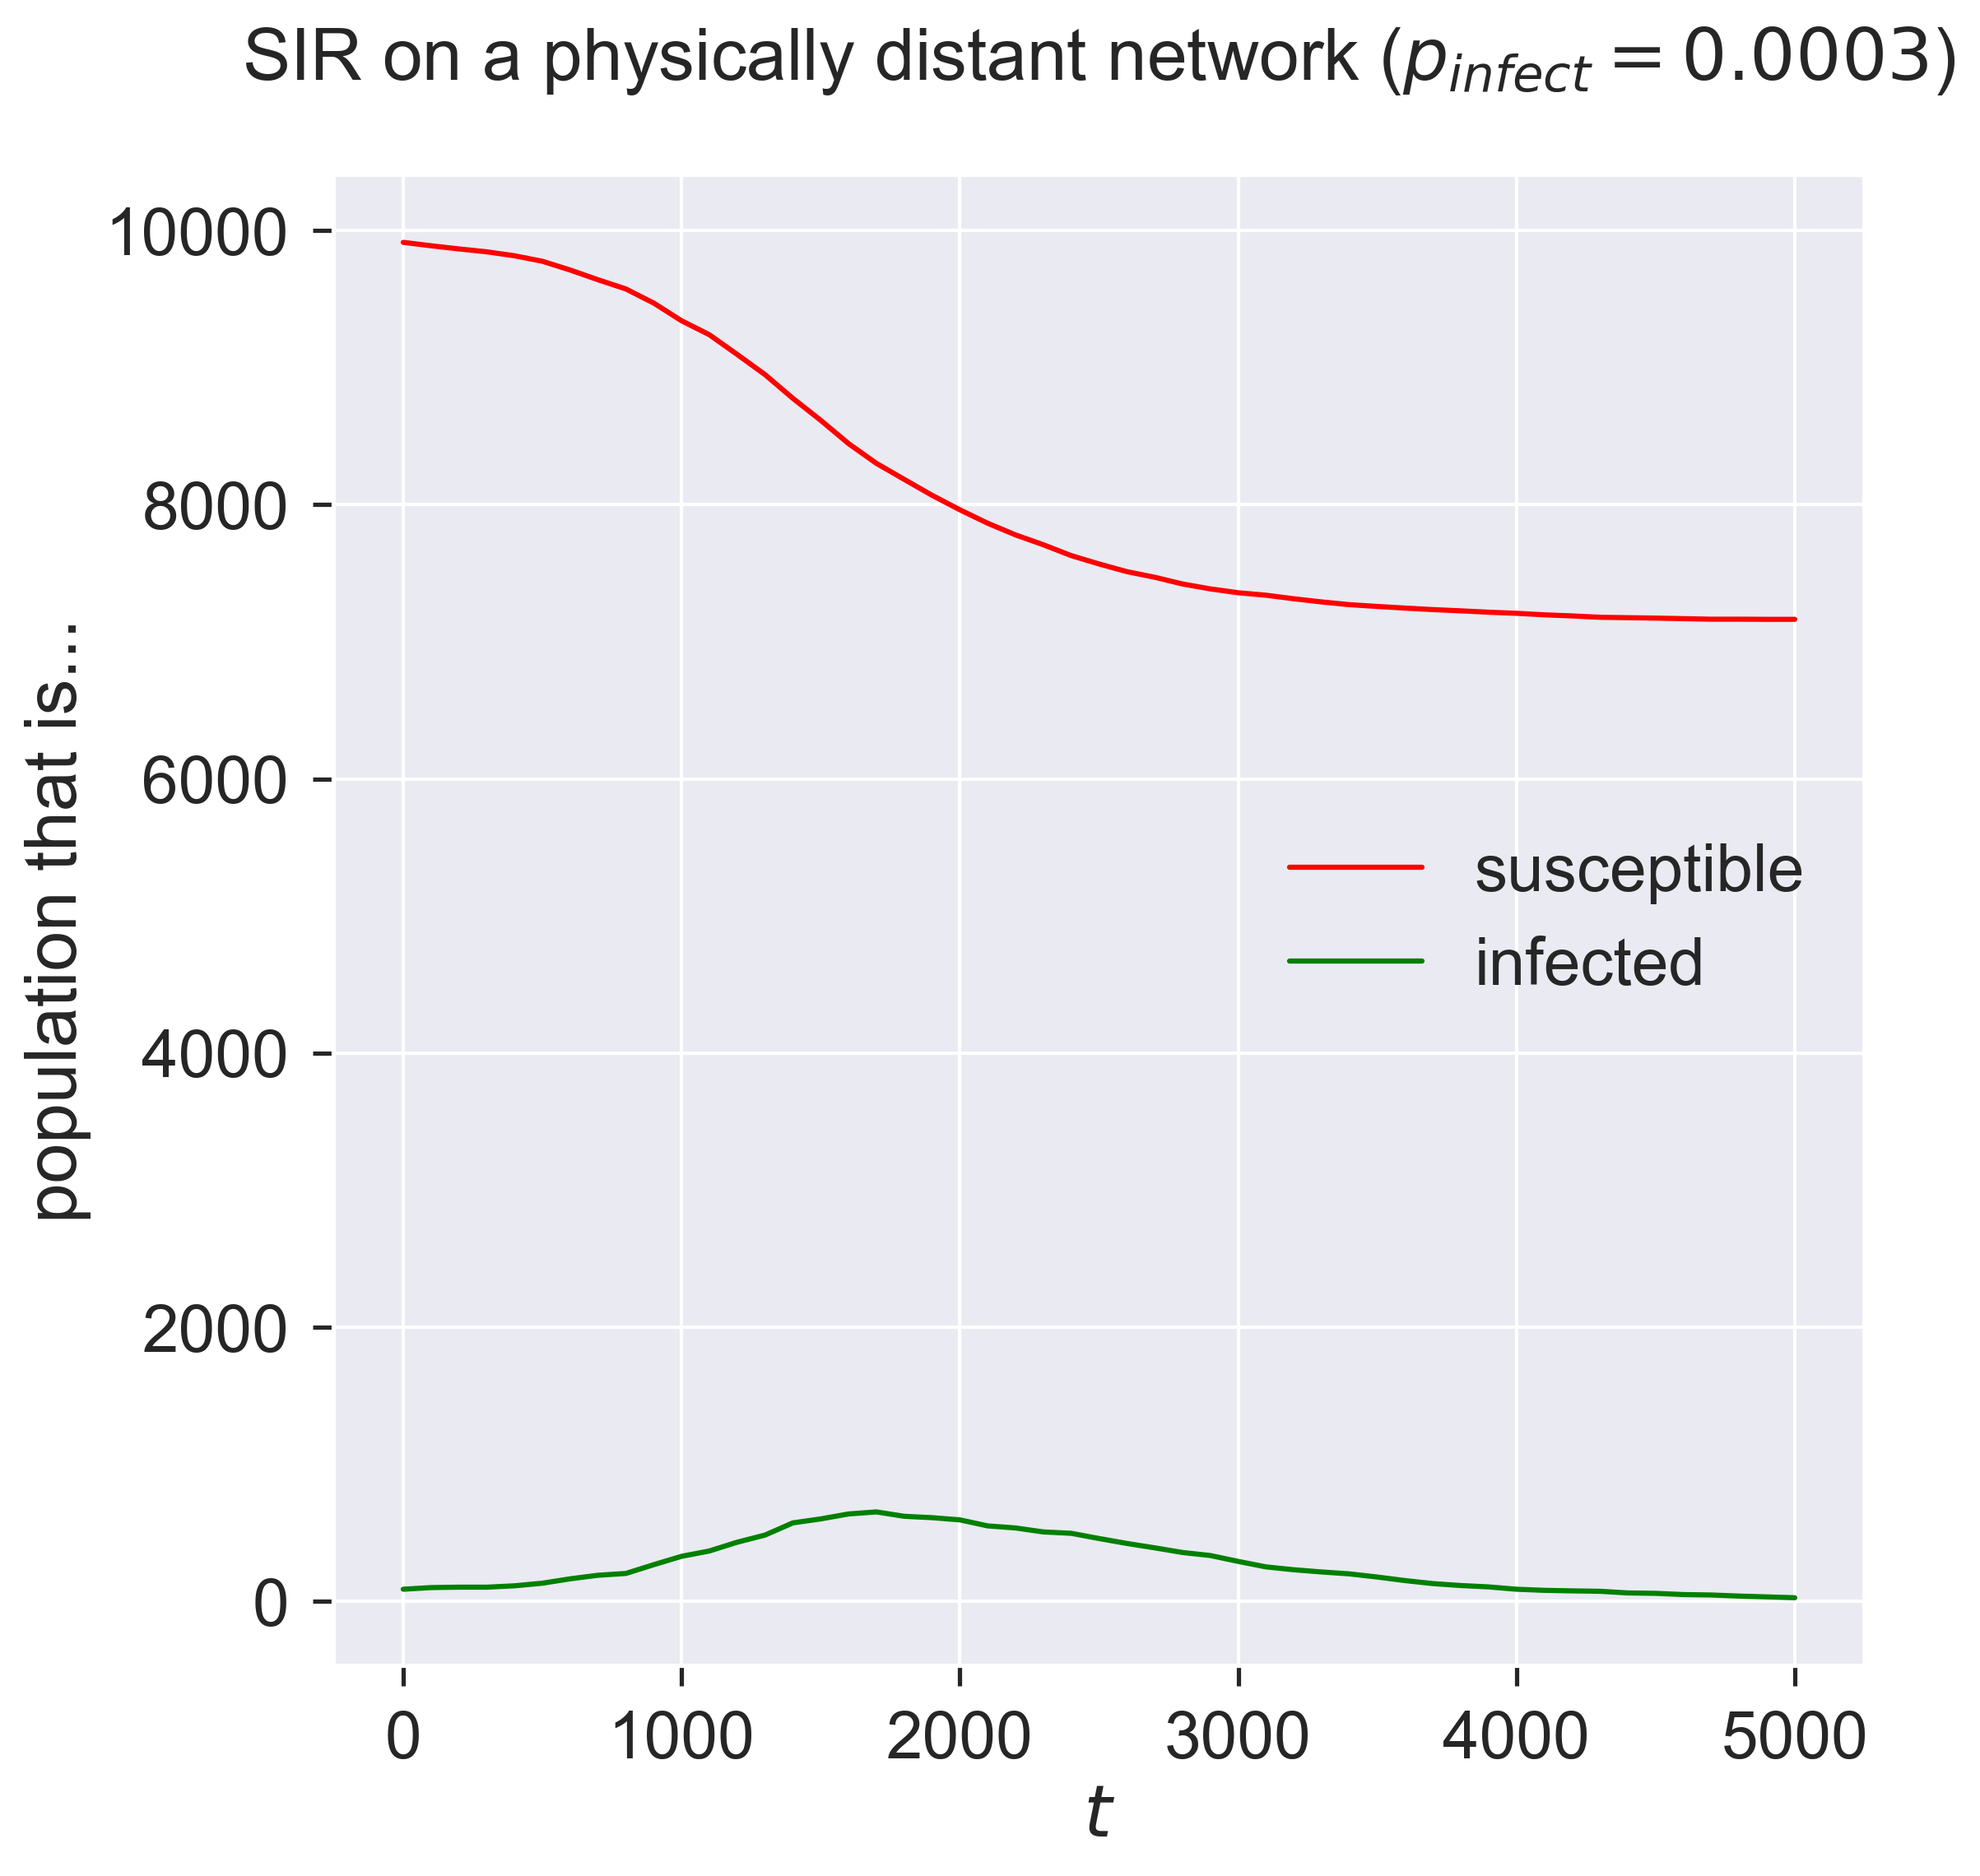

In [18]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

timeseries = rc[epyc.Experiment.RESULTS][epydemic.Monitor.TIMESERIES]
tss = timeseries[epydemic.Monitor.OBSERVATIONS]
sss = timeseries[epydemic.SIR.SUSCEPTIBLE]
iss = timeseries[epydemic.SIR.INFECTED]
rss = timeseries[epydemic.SIR.REMOVED]
ax.plot(tss, sss, 'r-', label='susceptible')
ax.plot(tss, iss, 'g-', label='infected')
#ax.plot(tss, rss, 'k-', label='removed')
ax.set_xlabel('$t$')
ax.set_ylabel('population that is...')
ax.legend(loc='center right')

# fine-time the figure
ax.set_title('SIR on a physically distant network ($p_{\mathit{infect}} = ' + '{p}$)'.format(p=pInfect), y=1.05)

_ = plt.show()

Compare this to the {ref}`same disease on an ER network <sec:thresholds-er>`. The epidemic doesn't really get started in the network, even for a value of $p_{\mathit{infect}}$ that previous experience would suggest would be sufficient. We can explore this by checking the size of the epidemic across a range of infectiousness values.

In [304]:
# network parameters
lab[PhyDistNetworkDynamics.N] = 10000
lab[PhyDistNetworkDynamics.BUBBLE_MEAN] = 4.5
lab[PhyDistNetworkDynamics.BUBBLE_STDDEV] = 2.0
lab[PhyDistNetworkDynamics.INTERBUBBLE_EXP] = 10.0

# disease parameters
lab[epydemic.SIR.P_INFECTED] = pInfected
lab[epydemic.SIR.P_INFECT] = numpy.linspace(0.0, 0.0008,
                                            num=100)
lab[epydemic.SIR.P_REMOVE] = pRemove

lab[epydemic.Monitor.DELTA] = T / 50

In [305]:
m = MonitoredSIR()
m.setMaximumTime(T)
e = PhyDistNetworkDynamics(m)
lab.runExperiment(epyc.RepeatedExperiment(
                    epyc.RepeatedExperiment(e, 10), 
                  10))

In [307]:
lab.readyFraction()

1.0

In [8]:
df = epyc.JSONLabNotebook('datasets/sir-phydist.json').dataframe()

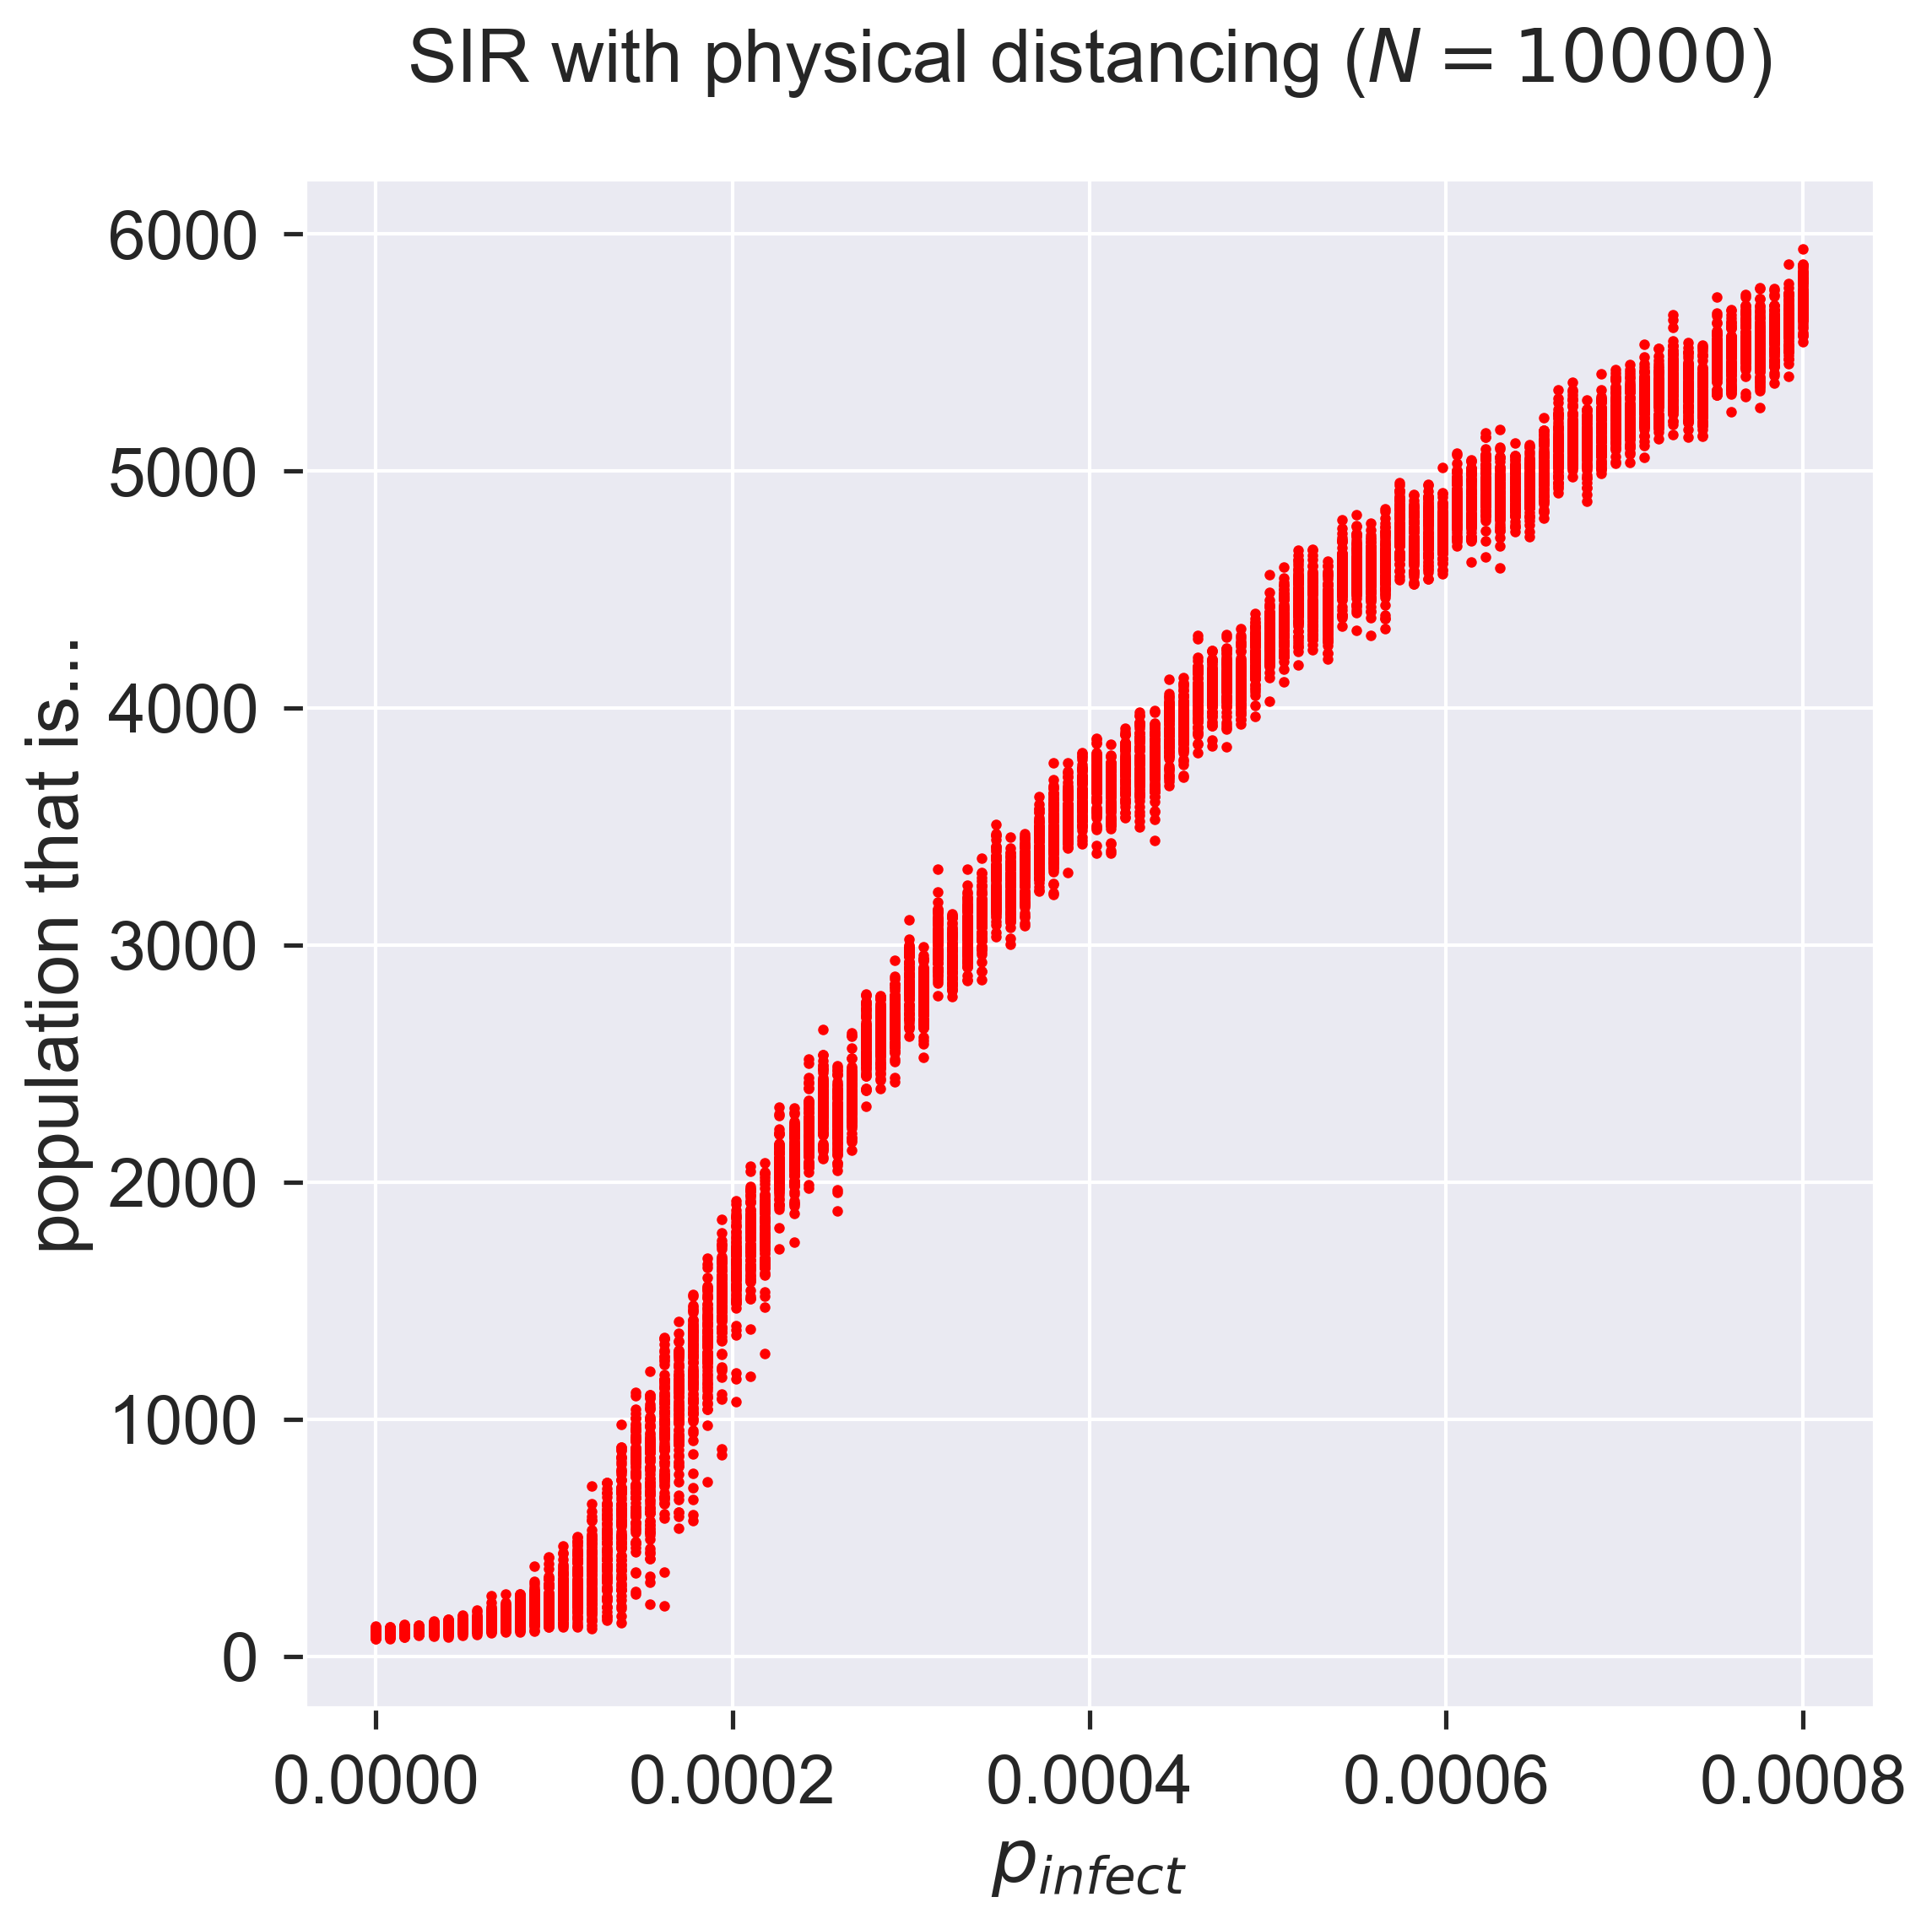

In [9]:
fig = plt.figure(figsize=(8, 8))
ax = fig.gca()

# plot the size of the removed population
ax.plot(df[epydemic.SIR.P_INFECT],
        df[epydemic.SIR.REMOVED], 'r.')
ax.set_xlabel('$p_{\\mathit{infect}}$')
ax.set_ylabel('population that is...')
ax.set_title('SIR with physical distancing ($N = {n}$)'.format(n=N), y=1.05)

plt.savefig('sir-phydist.png', dpi=300)
plt.show()

Comparing this with the {ref}`same disease on ER networks <sec:thresholds-er>` we see that the epidemic takes off similarly. Why is this? -- it would need more exploration, but the way we set up the socially distanced model did include powerlaw-distributed contacts between bubbles. It could be that these superspreaders are responsible for  spreading the disease between bubbles, at which point is spreads easily within them.

This brings up an important point about social distancing, and in particular about how to weaken such a lockdown. The size of {index}`bubbles <contact bubbles>`, and their interconnection doesn't matter **as long as there is no infection present in the bubble** &ndash; but it matters critically when there *is* infection, and especially if one of the bubble's contact points is highly connected. This makes the issue of acceptable behaviour very important, since smaller, more isolated, bubbles will both incur less infection within themselves (since there are fewer people) and potentially transmit less (by having fewer outside contacts). 

## Questions for discussion

- The case of Typhoid Mary raises some troubling questions. Is it right to lock someone up when they're done nothing personally wrong, to protect the community? What alternatives were there, before treatments like antibiotics were available? What might we do today?  
- Physical distancing doesn't have to be uniform for everyone. Some people are in more need of protection ("shielding") than others. How could we introduce this into a model?